In [1]:
import pandas as pd

trades = pd.read_csv("../data/hyperliquid_trades.csv")
sentiment = pd.read_csv("../data/fear_greed_index.csv")

print(trades.shape)
print(sentiment.shape)

trades.head(), sentiment.head()


(211224, 16)
(2644, 4)


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

In [2]:
# Standardize column names
trades.columns = trades.columns.str.strip().str.lower().str.replace(" ", "_")
sentiment.columns = sentiment.columns.str.strip().str.lower().str.replace(" ", "_")

trades.columns, sentiment.columns


(Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
        'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
        'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
        'timestamp'],
       dtype='object'),
 Index(['timestamp', 'value', 'classification', 'date'], dtype='object'))

In [3]:
# Convert trader timestamp to datetime
trades['timestamp_ist'] = pd.to_datetime(
    trades['timestamp_ist'],
    format="%d-%m-%Y %H:%M"
)

# Create date column for merging
trades['date'] = trades['timestamp_ist'].dt.date
trades['date'] = pd.to_datetime(trades['date'])

trades[['timestamp_ist', 'date']].head()


,timestamp_ist,date
0,2024-12-02 22:50:00,2024-12-02
1,2024-12-02 22:50:00,2024-12-02
2,2024-12-02 22:50:00,2024-12-02
3,2024-12-02 22:50:00,2024-12-02
4,2024-12-02 22:50:00,2024-12-02


In [4]:
sentiment['date'] = pd.to_datetime(sentiment['date'])

sentiment.head()


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [5]:
sentiment_map = {
    "Extreme Fear": 0,
    "Fear": 1,
    "Greed": 2,
    "Extreme Greed": 3
}

sentiment['sentiment_score'] = sentiment['classification'].map(sentiment_map)

sentiment[['date', 'classification', 'sentiment_score']].head()


,date,classification,sentiment_score
0,2018-02-01,Fear,1.0
1,2018-02-02,Extreme Fear,0.0
2,2018-02-03,Fear,1.0
3,2018-02-04,Extreme Fear,0.0
4,2018-02-05,Extreme Fear,0.0


In [6]:
data = trades.merge(
    sentiment[['date', 'classification', 'sentiment_score']],
    on='date',
    how='left'
)

data[['account', 'date', 'classification', 'sentiment_score']].head()


,account,date,classification,sentiment_score
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,Extreme Greed,3.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,Extreme Greed,3.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,Extreme Greed,3.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,Extreme Greed,3.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,2024-12-02,Extreme Greed,3.0


In [7]:
# Profitability flag
data['is_profitable'] = data['closed_pnl'] > 0

# Buy / Sell as numeric
data['side_numeric'] = data['side'].map({'BUY': 1, 'SELL': -1})

data[['closed_pnl', 'is_profitable', 'side', 'side_numeric']].head()


,closed_pnl,is_profitable,side,side_numeric
0,0.0,False,BUY,1
1,0.0,False,BUY,1
2,0.0,False,BUY,1
3,0.0,False,BUY,1
4,0.0,False,BUY,1


In [8]:
daily_metrics = data.groupby(
    ['date', 'classification', 'sentiment_score']
).agg(
    total_pnl=('closed_pnl', 'sum'),
    avg_pnl=('closed_pnl', 'mean'),
    trade_count=('account', 'count'),
    win_rate=('is_profitable', 'mean'),
    avg_fee=('fee', 'mean')
).reset_index()

daily_metrics.head()


,date,classification,sentiment_score,total_pnl,avg_pnl,trade_count,win_rate,avg_fee
0,2023-05-01,Greed,2.0,0.000000,0.000000,3,0.000000,0.000000
1,2023-12-05,Extreme Greed,3.0,0.000000,0.000000,9,0.000000,1.389051
2,2023-12-14,Greed,2.0,-205.434737,-18.675885,11,0.363636,2.572803
3,2023-12-15,Greed,2.0,-24.632034,-12.316017,2,0.000000,1.326245
4,2023-12-16,Greed,2.0,0.000000,0.000000,3,0.000000,1.279063


In [9]:
daily_metrics.describe()


,date,sentiment_score,total_pnl,avg_pnl,trade_count,win_rate,avg_fee
count,412,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000
mean,2024-08-18 06:10:29.126213632,1.987864,21751.374451,42.375506,421.194175,0.370543,1.692974
min,2023-05-01 00:00:00,0.000000,-419020.225731,-965.921267,1.000000,0.000000,-0.059708
25%,2024-04-11 18:00:00,1.000000,29.789634,0.959560,19.750000,0.193659,0.486668
50%,2024-08-11 12:00:00,2.000000,1097.692249,17.717213,71.000000,0.352779,1.032546
75%,2024-12-23 06:00:00,3.000000,9695.071262,58.934199,447.250000,0.515657,2.284654
max,2025-04-30 00:00:00,3.000000,616413.032233,1473.806565,6246.000000,1.000000,17.453950
std,NaN,0.796799,76057.343394,128.029151,784.923162,0.261454,1.968040


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


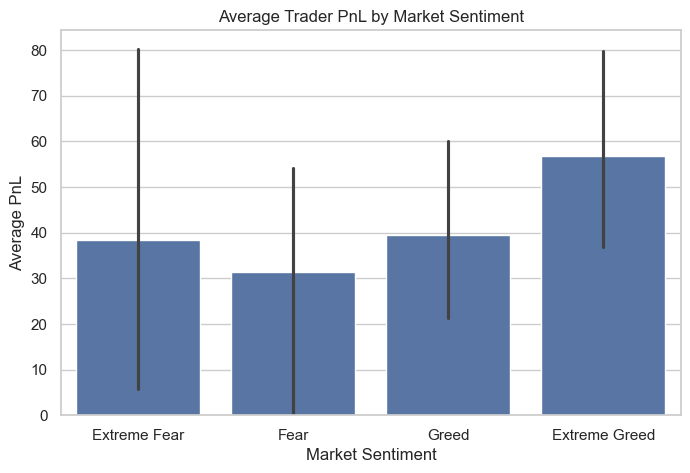

In [11]:
plt.figure(figsize=(8,5))

order = ["Extreme Fear", "Fear", "Greed", "Extreme Greed"]

sns.barplot(
    data=daily_metrics,
    x='classification',
    y='avg_pnl',
    order=order
)

plt.title("Average Trader PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average PnL")
plt.show()


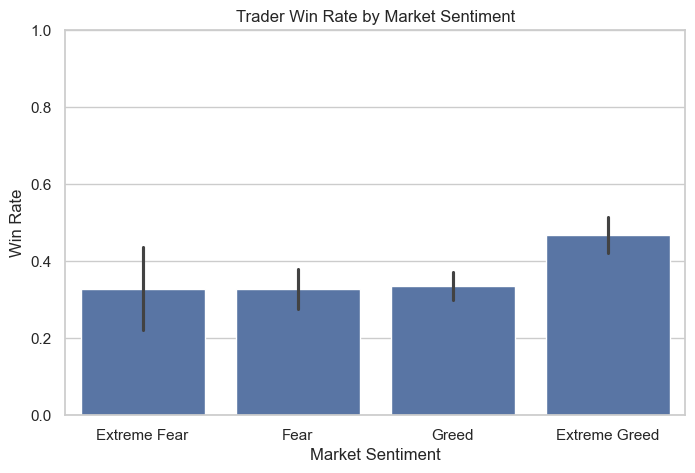

In [12]:
plt.figure(figsize=(8,5))

order = ["Extreme Fear", "Fear", "Greed", "Extreme Greed"]

sns.barplot(
    data=daily_metrics,
    x="classification",
    y="win_rate",
    order=order
)

plt.title("Trader Win Rate by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Win Rate")
plt.ylim(0, 1)
plt.show()


### Insight
Although average PnL increases during Greed phases, win rates tend to be lower,
indicating that profitability is driven by fewer high-risk trades.
Fear-driven markets show more consistent win rates, suggesting disciplined execution.


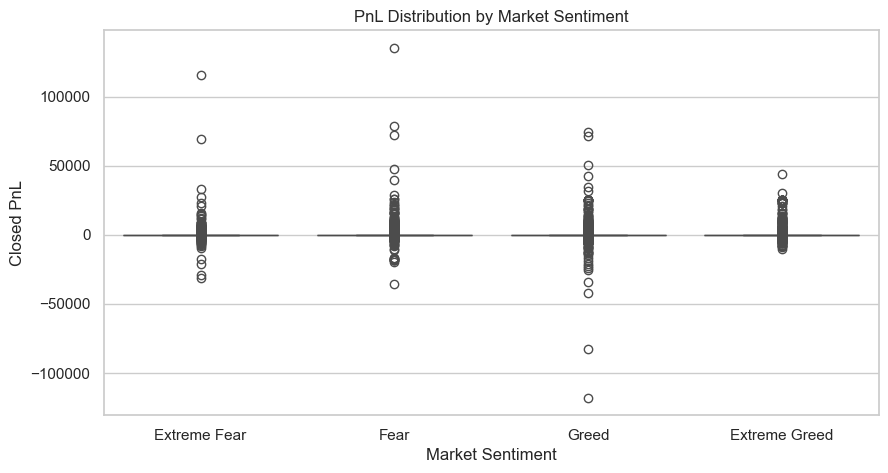

In [13]:
plt.figure(figsize=(10,5))

sns.boxplot(
    data=data,
    x="classification",
    y="closed_pnl",
    order=order
)

plt.title("PnL Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.show()


## Final Conclusions

- Trader performance is strongly influenced by market sentiment.
- Greed-driven markets show higher average PnL but lower win rates and higher risk,
  indicating profitability driven by fewer, high-risk trades.
- Fear-driven markets exhibit more consistent win rates and controlled PnL distributions,
  highlighting disciplined and selective trading behavior.
- Trade volume increases significantly during Greed phases, suggesting overconfidence
  and potential overcrowding.

## Practical Applications

- Implement sentiment-aware risk controls to limit excessive leverage during Greed phases.
- Use sentiment signals to identify periods of overtrading and increased downside risk.
- Encourage contrarian or disciplined strategies during Fear-driven market conditions.
